# DSC 180A Paper Replication
### Microbial Diversity in Clinical Microbiome Studies: Sample Size and Statistical Power Considerations
## Setup

## Imports

In [48]:
import pandas as pd
import numpy as np
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt
import re

from statsmodels.stats.power import tt_ind_solve_power
from statistics import mean, stdev
from skbio import DistanceMatrix
from qiime2.plugins import fragment_insertion, diversity, emperor
from qiime2 import Metadata, Artifact
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.phylogeny.methods import midpoint_root
from skbio import TreeNode
from skbio.diversity.alpha import faith_pd

import rpy2.robjects as ro
from rpy2.robjects.packages import isinstalled

import skbio
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import shap
from biom import load_table

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## Data Preprocessing

In [2]:
ft = Artifact.load('qiita_artifacts/78873_feature-table.qza')
ft_df = ft.view(pd.DataFrame)
ft_df.head()

,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACC,ACGTAGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTTAAGTCAGGAGTGAAAGGCTACGGCTCAACC,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACGGGCAAGTCTGAAGTGAAAGGCAGGGGCTCAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACG,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTTAACC,ACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACT,...,ACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGTCAGCAAGTCCGTTGTTAAATCTACCGGCTCAACC,ATGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGAGTAGGCGGGATTACAAGTCTGATGTGAAATACCGAGGCTTAACT,ACATAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGCGTGCAGCCGGGCCGGCAAGTCAGATGTGAAATCTGGAGGCTTAACC,ATGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGCGGATTAAGTCCGGAGTAAAATTGTGGGGCTCAACC,ACATAGGGGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCATCGTAAGTCTGTTGTGAAAGGCGATGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGTAGATCAAGTCGCATGTGAAATACCCGGGCTCAACC,ATGTAGGGGGCGAGCGTTATCCGGAATCATTGGGCGTAAAGAGCGCGTAGGCGGCCCCTCAAGCGGGATCTCTAATCCGAGGGCTCAACC,AGGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGAGTAGGCGGCACGGCAAGTAAGATGTGAAAGCCCACGGCTTAACT,ACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTATGCCGTCTTCTGCTTGAAAAAAGAAAATTTGCGGCTCAACC,ACCTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACC
1629.SubjectIBD026,46430.0,18924.0,6645.0,5276.0,4450.0,2324.0,1322.0,1279.0,1043.0,915.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD414,0.0,41.0,0.0,82.0,0.0,0.0,0.0,1429.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD244,1551.0,1089.0,0.0,3248.0,0.0,4385.0,0.0,15048.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD198,0.0,8573.0,0.0,21.0,0.0,0.0,0.0,271.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
rarefied = rarefy(table=ft, sampling_depth=10000).rarefied_table
# rarefied.save('rarefied_table.qza')

In [4]:
# using previously generated tree
rarefied = q2.Artifact.load('out/rarefied_table.qza')

In [5]:
rarefied_df = rarefied.view(pd.DataFrame)
rarefied_df.sum(axis=1)

1629.SubjectIBD026    10000.0
1629.SubjectIBD414    10000.0
1629.SubjectIBD244    10000.0
1629.SubjectIBD198    10000.0
1629.SubjectIBD391    10000.0
                       ...   
1629.SubjectIBD222    10000.0
1629.SubjectIBD195    10000.0
1629.SubjectIBD472    10000.0
1629.SubjectIBD040    10000.0
1629.SubjectIBD249    10000.0
Length: 611, dtype: float64

In [6]:
insertion_tree = q2.Artifact.load('qiita_artifacts/insertion-tree.qza')

faith_res = diversity.actions.alpha_phylogenetic(
    table=rarefied,
    phylogeny=insertion_tree,
    metric='faith_pd'
)

faith_pd = faith_res.alpha_diversity.view(pd.Series)
faith_pd

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/mwdai/processes/64928-1763498637.28@mwdai/tmp/q2-OutPath-yabjuxge -t /tmp/qiime2/mwdai/data/6d8525f0-12b8-4361-a347-179138f80e23/data/tree.nwk -o /tmp/qiime2/mwdai/processes/64928-1763498637.28@mwdai/tmp/q2-OutPath-gnkornjm



1629.SubjectIBD026     9.218486
1629.SubjectIBD414    11.756760
1629.SubjectIBD244    12.795849
1629.SubjectIBD198    14.334325
1629.SubjectIBD391    19.967389
                        ...    
1629.SubjectIBD222    13.261706
1629.SubjectIBD195    28.379441
1629.SubjectIBD472    15.631741
1629.SubjectIBD040    21.643152
1629.SubjectIBD249     5.644833
Name: faith_pd, Length: 611, dtype: float64

In [7]:
insertion_tree = q2.Artifact.load('qiita_artifacts/insertion-tree.qza')

faith_res = diversity.actions.alpha_phylogenetic(
    table=rarefied,
    phylogeny=insertion_tree,
    metric='faith_pd'
)

faith_pd = faith_res.alpha_diversity.view(pd.Series)
faith_pd

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/mwdai/processes/64928-1763498637.28@mwdai/tmp/q2-OutPath-3q8ci29v -t /tmp/qiime2/mwdai/data/6d8525f0-12b8-4361-a347-179138f80e23/data/tree.nwk -o /tmp/qiime2/mwdai/processes/64928-1763498637.28@mwdai/tmp/q2-OutPath-mbnsb1m0



1629.SubjectIBD026     9.218486
1629.SubjectIBD414    11.756760
1629.SubjectIBD244    12.795849
1629.SubjectIBD198    14.334325
1629.SubjectIBD391    19.967389
                        ...    
1629.SubjectIBD222    13.261706
1629.SubjectIBD195    28.379441
1629.SubjectIBD472    15.631741
1629.SubjectIBD040    21.643152
1629.SubjectIBD249     5.644833
Name: faith_pd, Length: 611, dtype: float64

In [8]:
unifrac_res = diversity.actions.beta_phylogenetic(
    table=rarefied,
    phylogeny=insertion_tree,
    metric='unweighted_unifrac'
)
unifrac_dm = unifrac_res.distance_matrix.view(DistanceMatrix)
unifrac_df = pd.DataFrame(unifrac_dm.data, index=unifrac_dm.ids, columns=unifrac_dm.ids)
unifrac_df

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /tmp/qiime2/mwdai/data/73849635-f9a0-48d1-bad0-770058ae1328/data/feature-table.biom -t /tmp/qiime2/mwdai/data/6d8525f0-12b8-4361-a347-179138f80e23/data/tree.nwk -m unweighted -o /tmp/qiime2/mwdai/processes/64928-1763498637.28@mwdai/tmp/q2-OutPath-9ffon94p



,1629.SubjectIBD026,1629.SubjectIBD414,1629.SubjectIBD244,1629.SubjectIBD198,1629.SubjectIBD391,1629.SubjectIBD105,1629.SubjectIBD537,1629.SubjectIBD489,1629.SubjectIBD367,1629.SubjectIBD069,...,1629.SubjectIBD108,1629.SubjectIBD551,1629.SubjectIBD163,1629.SubjectIBD484,1629.SubjectIBD419,1629.SubjectIBD222,1629.SubjectIBD195,1629.SubjectIBD472,1629.SubjectIBD040,1629.SubjectIBD249
1629.SubjectIBD026,0.000000,0.648787,0.624416,0.650742,0.711483,0.655566,0.653168,0.632705,0.548126,0.657685,...,0.488114,0.498691,0.558711,0.700636,0.664620,0.693628,0.763684,0.686680,0.709866,0.625799
1629.SubjectIBD414,0.648787,0.000000,0.616524,0.524910,0.618797,0.539021,0.570974,0.516736,0.499461,0.504975,...,0.555089,0.642244,0.610004,0.590377,0.494473,0.565866,0.686550,0.528995,0.619293,0.668622
1629.SubjectIBD244,0.624416,0.616524,0.000000,0.626309,0.660915,0.577175,0.653440,0.616850,0.648780,0.656195,...,0.591446,0.672282,0.584811,0.702893,0.601442,0.691848,0.745228,0.649071,0.659680,0.635612
1629.SubjectIBD198,0.650742,0.524910,0.626309,0.000000,0.605392,0.489399,0.522514,0.496356,0.553480,0.540189,...,0.561066,0.642769,0.601990,0.575249,0.538131,0.596421,0.582543,0.556553,0.553124,0.666041
1629.SubjectIBD391,0.711483,0.618797,0.660915,0.605392,0.000000,0.644372,0.528634,0.521613,0.707932,0.573718,...,0.623675,0.720940,0.693556,0.536476,0.567414,0.569887,0.585519,0.564907,0.545245,0.781747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD222,0.693628,0.565866,0.691848,0.596421,0.569887,0.619961,0.616600,0.618853,0.617235,0.579017,...,0.622648,0.682509,0.638022,0.614998,0.599155,0.000000,0.664798,0.576487,0.599157,0.720853
1629.SubjectIBD195,0.763684,0.686550,0.745228,0.582543,0.585519,0.700442,0.578039,0.554256,0.762651,0.631907,...,0.698169,0.732233,0.762382,0.546889,0.673666,0.664798,0.000000,0.632679,0.566376,0.824911
1629.SubjectIBD472,0.686680,0.528995,0.649071,0.556553,0.564907,0.549319,0.557592,0.548465,0.641215,0.467034,...,0.600624,0.711919,0.675137,0.595560,0.557350,0.576487,0.632679,0.000000,0.510521,0.740173
1629.SubjectIBD040,0.709866,0.619293,0.659680,0.553124,0.545245,0.621051,0.544614,0.520898,0.699949,0.549285,...,0.623824,0.717842,0.688796,0.561837,0.614761,0.599157,0.566376,0.510521,0.000000,0.756297


In [9]:
# faith_res.alpha_diversity.save('alpha_diversity.qza')
# unifrac_res.distance_matrix.save('distance_matrix.qza')

## Processing data

In [10]:
metadata_df = pd.read_csv('qiita_artifacts/25761_25761_analysis_mapping.txt', 
                       sep='\t', dtype=str, index_col=0, engine='python')
metadata_df.head()

,BarcodeSequence,LinkerPrimerSequence,center_name,experiment_design_description,instrument_model,library_construction_protocol,linker,pcr_primers,platform,run_center,...,study_id,timepoint,uc_extent,year_diagnosed,qiita_artifact_id,qiita_study_title,qiita_study_alias,qiita_owner,qiita_principal_investigator,Description
SampleID,,,,,,,,,,,,,,,,,,,,,
1629.SubjectIBD403,GTAGAGCT,GTGCCAGCMGCCGCGGTAA,LBNL,Jansson_Lamendella_Crohns,Illumina HiSeq 2000,Illumina V4 515F/806RBC,GT,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,Yale Center for Genome Analysis,...,1629,3,Left sided (E2),2007,43623,Dynamics of the gut microbiome in Inflammatory...,Jansson_Lamendella_Crohns,Gail Ackermann,Janet Jansson,SubjectIBD403
1629.SubjectIBD062,AACCGTTC,GTGCCAGCMGCCGCGGTAA,LBNL,Jansson_Lamendella_Crohns,Illumina HiSeq 2000,Illumina V4 515F/806RBC,GT,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,Yale Center for Genome Analysis,...,1629,1,not applicable,1972,43623,Dynamics of the gut microbiome in Inflammatory...,Jansson_Lamendella_Crohns,Gail Ackermann,Janet Jansson,SubjectIBD062
1629.SubjectIBD396,GCCTCCCT,GTGCCAGCMGCCGCGGTAA,LBNL,Jansson_Lamendella_Crohns,Illumina HiSeq 2000,Illumina V4 515F/806RBC,GT,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,Yale Center for Genome Analysis,...,1629,5,not applicable,2007,43623,Dynamics of the gut microbiome in Inflammatory...,Jansson_Lamendella_Crohns,Gail Ackermann,Janet Jansson,SubjectIBD396
1629.SubjectIBD041,TGATGCTA,GTGCCAGCMGCCGCGGTAA,LBNL,Jansson_Lamendella_Crohns,Illumina HiSeq 2000,Illumina V4 515F/806RBC,GT,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,Yale Center for Genome Analysis,...,1629,2,Extensive (E3),1979,43623,Dynamics of the gut microbiome in Inflammatory...,Jansson_Lamendella_Crohns,Gail Ackermann,Janet Jansson,SubjectIBD041
1629.SubjectIBD090,AAGACACA,GTGCCAGCMGCCGCGGTAA,LBNL,Jansson_Lamendella_Crohns,Illumina HiSeq 2000,Illumina V4 515F/806RBC,GT,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,Yale Center for Genome Analysis,...,1629,3,Left sided (E2),1977,43623,Dynamics of the gut microbiome in Inflammatory...,Jansson_Lamendella_Crohns,Gail Ackermann,Janet Jansson,SubjectIBD090


In [11]:
metadata_df['deblur alpha diversity'] = faith_pd
metadata_df.dropna(subset=['deblur alpha diversity'], inplace=True)

b1 = metadata_df[metadata_df['cd_behavior'] == 'Non-stricturing, non-penetrating (B1)']
bother = metadata_df[(metadata_df['cd_behavior'] != 'Non-stricturing, non-penetrating (B1)') & 
                  (metadata_df['cd_behavior'] != 'not applicable')]

b1_dtx = unifrac_dm.filter(ids=b1.index).to_series().values
bother_dtx = unifrac_dm.filter(ids=bother.index).to_series().values

In [12]:
# # alpha
# sd1 = b1['deblur alpha diversity'].std()
# sd2 = bother['deblur alpha diversity'].std()
# sd12 = mean([sd1, sd2])

# #since we used a different tree, our alpha diversity values are scaled by about this value
# #faith's pd = sum of branch lengths 
# #Faith’s PD: reflects the absolute size/scale of the tree, so the PD values are way larger.
# #UniFrac: uses ratios of branch lengths, so it's mostly unaffected by that global scale difference
# scale = 4.5e2

# base_diffs = [2, 3, 4]                     
# scaled_diffs = [d * scale for d in base_diffs]

# alpha = 0.05
# data_alpha = []
# for observations in range(10, 155, 5):
#     for difference in scaled_diffs:
#         effect_size = difference/sd12
#         x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
#                                alpha=alpha, ratio=1.0,
#                                alternative='two-sided')
#         data_alpha.append({
#             'alpha': alpha, 'Power (1-β)': x, 
#             'Total sample size (N)': observations * 2, 
#             'Difference': '%d (effect size %0.2f)' % (
#                 difference, effect_size)})
# data_alpha = pd.DataFrame(data_alpha) 

# # beta
# u2u1 = abs(mean(b1_dtx) - mean(bother_dtx))
# effect_size = u2u1/mean([stdev(b1_dtx), stdev(bother_dtx)])

# data_beta = []
# for observations in range(10, 155, 5):
#     for alpha in [.001, .01, .05, .1]:
#         x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
#                                alpha=alpha, ratio=1.0,
#                                alternative='two-sided')
#         data_beta.append({
#             'Significance level (α)': alpha, 'Power (1-β)': x, 
#             'Total sample size (N)': observations * 2, 
#             'Difference': '%d (effect size %0.2f)' % (
#                 difference, effect_size)})
# data_beta = pd.DataFrame(data_beta) 

# alpha
sd1 = b1['deblur alpha diversity'].std()
sd2 = bother['deblur alpha diversity'].std()
sd12 = mean([sd1, sd2])

alpha = 0.05
data_alpha = []
for observations in range(10, 155, 5):
    for difference in [2, 3, 4]:
        effect_size = difference/sd12
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_alpha.append({
            'alpha': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_alpha = pd.DataFrame(data_alpha) 

# beta
u2u1 = abs(mean(b1_dtx) - mean(bother_dtx))
effect_size = u2u1/mean([stdev(b1_dtx), stdev(bother_dtx)])

data_beta = []
for observations in range(10, 155, 5):
    for alpha in [.001, .01, .05, .1]:
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_beta.append({
            'Significance level (α)': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_beta = pd.DataFrame(data_beta) 

In [13]:
print ('Alpha diversity:',
    b1['deblur alpha diversity'].mean(),
    bother['deblur alpha diversity'].mean(),
    
    b1['deblur alpha diversity'].std(),
    bother['deblur alpha diversity'].std())

print ('Beta diversity:',
    mean(b1_dtx),
    mean(bother_dtx),
    
    stdev(b1_dtx),
    stdev(bother_dtx))

Alpha diversity: 13.507633703437431 9.853001344697088 3.4693246714146757 3.8647544662713034
Beta diversity: 0.5602785990001541 0.6137847859525319 0.08891030703379714 0.08818211544690703


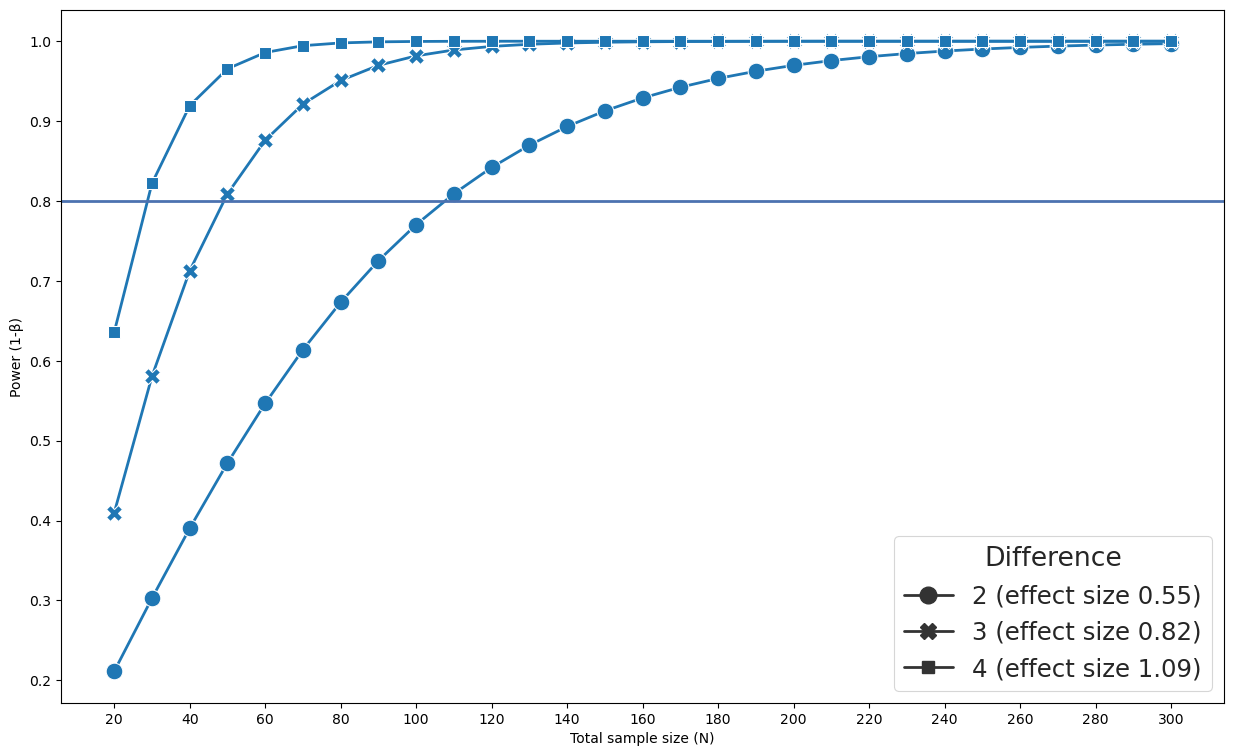

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 9))

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2, 
                rc={'lines.linewidth': 2, 'lines.markersize': 12})

f = sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
                 markers=True, dashes=False, style='Difference',
                 ax=ax1, data=data_alpha)
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

plt.axhline(0.8, 0, data_alpha['Total sample size (N)'].max())

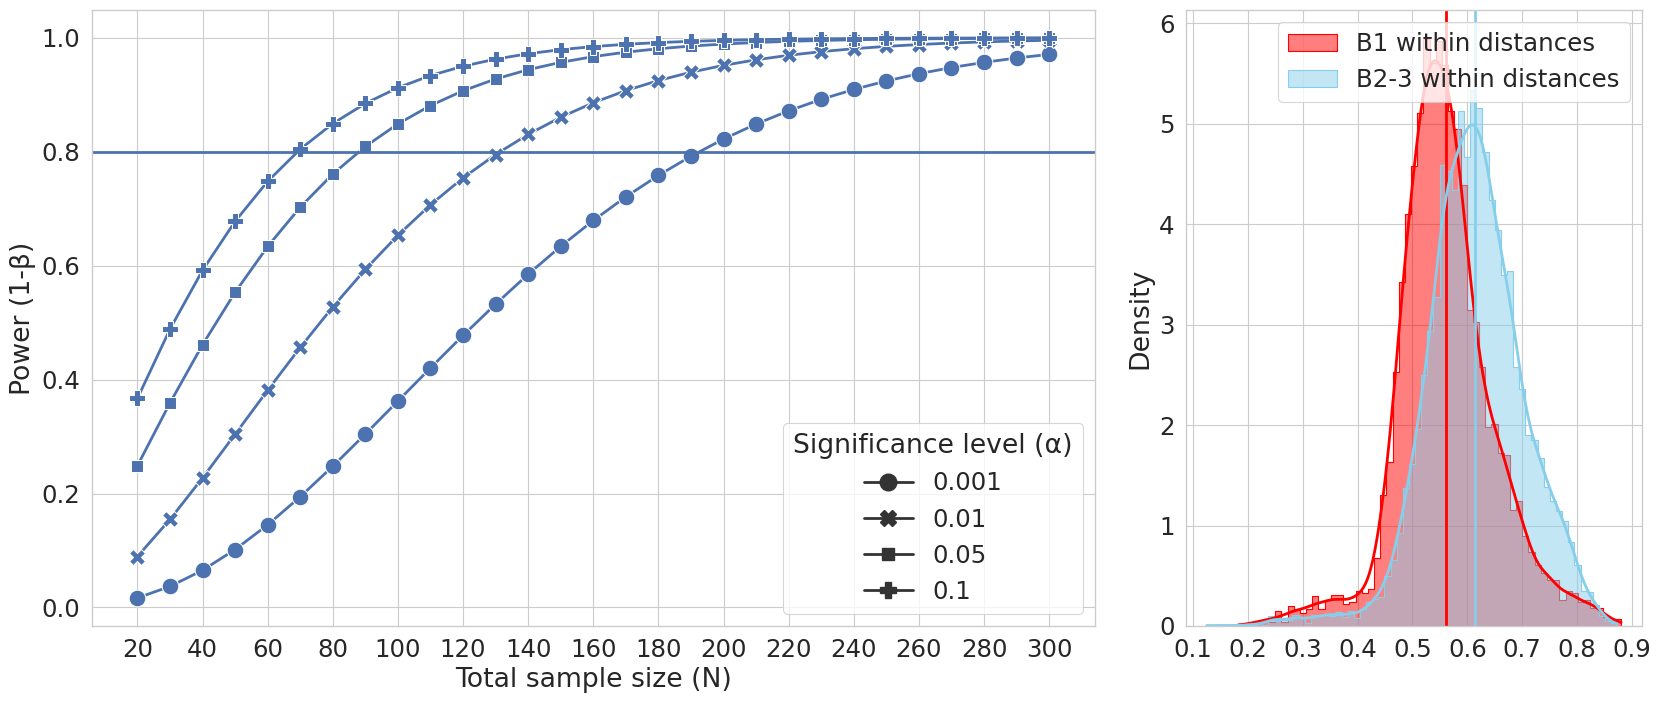

In [15]:
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(ncols=3, nrows=1, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[0, :2])
ax2 = fig.add_subplot(grid[0, 2:])

# LEFT: beta power curves (unchanged)
sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
             style='Significance level (α)',
             markers=True, dashes=False,
             ax=ax1, data=data_beta)
ax1.axhline(0.8, 0, data_beta['Total sample size (N)'].max())
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

# RIGHT: distributions using histplot (+ KDE) instead of distplot
sns.histplot(b1_dtx,
             label="B1 within distances",
             color="red",
             kde=True,
             stat="density",
             element="step",
             ax=ax2)

ax2.axvline(mean(b1_dtx), 0, 6, color="red")

sns.histplot(bother_dtx,
             label="B2-3 within distances",
             color="skyblue",
             kde=True,
             stat="density",
             element="step",
             ax=ax2)

ax2.axvline(mean(bother_dtx), 0, 6, color="skyblue")

ax2.xaxis.set_major_locator(plt.MultipleLocator(.1))
ax2.legend()

In [16]:
# Perform PCoA on the unweighted UniFrac distance matrix and visualize with Emperor
pcoa_res = diversity.methods.pcoa(distance_matrix=unifrac_res.distance_matrix)

metadata = Metadata.load('qiita_artifacts/25761_25761_analysis_mapping.txt')

viz = emperor.visualizers.plot(
    pcoa=pcoa_res.pcoa,
    metadata=metadata
)

ordination: skbio.OrdinationResults = pcoa_res.pcoa.view(skbio.OrdinationResults)
coords = ordination.samples.copy()
coords.index.name = 'SampleID'

df = coords.join(metadata_df, how='inner')

df = df[df['cd_behavior'] != 'not applicable'].copy()

df['behavior_group'] = df['cd_behavior'].apply(
    lambda x: 'B1' if x == 'Non-stricturing, non-penetrating (B1)' else 'B-other'
)
df['behavior_group'] = pd.Categorical(df['behavior_group'],
                                      categories=['B1', 'B-other'],
                                      ordered=True)

pc1_col = coords.columns[0]
pc2_col = coords.columns[1]

pc1_var = ordination.proportion_explained.iloc[0] * 100
pc2_var = ordination.proportion_explained.iloc[1] * 100

x_lab = f"{pc1_col} ({pc1_var:.1f}% var)"
y_lab = f"{pc2_col} ({pc2_var:.1f}% var)"

fig = px.scatter(
    df,
    x=pc1_col,
    y=pc2_col,
    color='behavior_group',   
    hover_name=df.index,
    hover_data=df.columns,
    title="Unweighted UniFrac PCoA"
)

fig.update_layout(
    xaxis_title=x_lab,
    yaxis_title=y_lab
)

fig.write_html('figs/figure3.html')

/home/mwdai/miniforge3/envs/qiime2-amplicon-2025.7/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.058321648805676585 and the largest is 21.085930153054083.
  warn(


   N_total  mean_auc   std_auc  n_reps
0       40  0.891528  0.013336      10
1       60  0.898426  0.019991      10
2       80  0.897593  0.013161      10
3      100  0.911204  0.012520      10
4      120  0.919630  0.005156      10


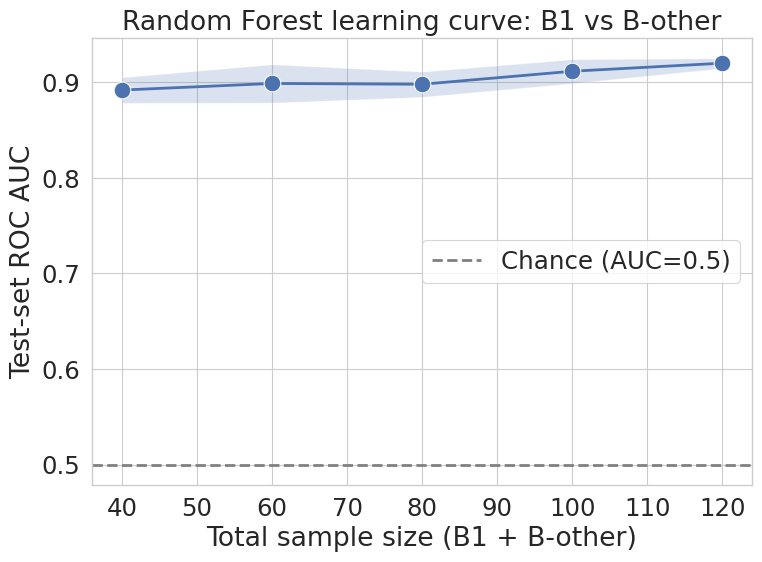

In [69]:
#Random Forest Classification
meta_rf = metadata_df.copy()
meta_rf = meta_rf[meta_rf['cd_behavior'] != 'not applicable'].copy()
meta_rf['behavior_group'] = np.where(
    meta_rf['cd_behavior'] == 'Non-stricturing, non-penetrating (B1)',
    'B1',
    'B-other'
)

common_ids = rarefied_df.index.intersection(meta_rf.index)

X_full = rarefied_df.loc[common_ids]
y_full = meta_rf.loc[common_ids, 'behavior_group']

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.3,
    stratify=y_full,
    random_state=42,
)

def rf_learning_curve(X_train,y_train,X_test,y_test,sample_sizes,n_reps=10,random_state=42):
    rng = np.random.default_rng(random_state)

    Xtr = X_train.values
    ytr = y_train.values
    Xte = X_test.values
    yte = y_test.values

    classes = np.unique(ytr)
    if len(classes) != 2:
        raise ValueError(f"Expected 2 classes, got {classes}")

    class_to_idx = {c: np.where(ytr == c)[0] for c in classes}
    min_class_size = min(len(idx) for idx in class_to_idx.values())
    max_balanced_N = 2 * min_class_size

    sample_sizes = [N for N in sample_sizes if N <= max_balanced_N]

    results = []

    yte_bin = (yte == classes[1]).astype(int)

    for N in sample_sizes:
        n_per_class = N // 2
        aucs = []

        for rep in range(n_reps):
            chosen_idxs = []

            for c in classes:
                idxs = class_to_idx[c]
                chosen = rng.choice(idxs, size=n_per_class, replace=False)
                chosen_idxs.append(chosen)

            chosen_idxs = np.concatenate(chosen_idxs)

            X_sub = Xtr[chosen_idxs]
            y_sub = ytr[chosen_idxs]

            clf = RandomForestClassifier(
                n_estimators=500,
                max_depth=None,
                class_weight="balanced",
                n_jobs=-1,
                random_state=random_state + rep,
            )
            clf.fit(X_sub, y_sub)

            y_prob = clf.predict_proba(Xte)[:, 1]
            auc = roc_auc_score(yte_bin, y_prob)
            aucs.append(auc)

        results.append(
            {
                "N_total": N,
                "mean_auc": np.mean(aucs),
                "std_auc": np.std(aucs),
                "n_reps": len(aucs),
            }
        )

    return pd.DataFrame(results)

sample_sizes = list(range(40, X_train.shape[0] * 2, 20))

rf_results = rf_learning_curve(
    X_train,
    y_train,
    X_test,
    y_test,
    sample_sizes,
    n_reps=10,
)

print(rf_results)

plt.figure(figsize=(8, 6))
sns.lineplot(x="N_total", y="mean_auc", data=rf_results, marker="o")
plt.fill_between(
    rf_results["N_total"],
    rf_results["mean_auc"] - rf_results["std_auc"],
    rf_results["mean_auc"] + rf_results["std_auc"],
    alpha=0.2,
)
plt.axhline(0.5, color="gray", linestyle="--", label="Chance (AUC=0.5)")
plt.xlabel("Total sample size (B1 + B-other)")
plt.ylabel("Test-set ROC AUC")
plt.title("Random Forest learning curve: B1 vs B-other")
plt.legend()
plt.tight_layout()
plt.savefig("figs/figure4.pdf")
plt.show()

#Which features are most important in classification?
rf_final = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
)
rf_final.fit(X_train, y_train)

importances = rf_final.feature_importances_

feat_names = X_train.columns 
imp_df = pd.DataFrame({
    'feature': feat_names,
    'gini_importance': importances
})

imp_df = imp_df.sort_values('gini_importance', ascending=False)
imp_df.to_csv('figs/rf_feature_importances.csv', index=False)

#Permutation importance
y_prob = rf_final.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score((y_test == rf_final.classes_[1]).astype(int), y_prob)

perm = permutation_importance(
    rf_final,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc',
)

perm_importances = perm.importances_mean  
perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'perm_importance_auc_drop': perm_importances
})

perm_df = perm_df.sort_values('perm_importance_auc_drop', ascending=False)
perm_df.to_csv('figs/rf_feature_importances_permutation.csv', index=False)


In [70]:
perm_df

,feature,perm_importance_auc_drop
268,ACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGC...,0.007014
47,ACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGC...,0.005509
21,ACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...,0.005324
472,ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCAC...,0.004259
109,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...,0.004097
...,...,...
0,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...,-0.002014
120,ACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...,-0.002361
161,ACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGT...,-0.002384
40,ACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...,-0.002593


In [58]:
table = Artifact.import_data('FeatureTable[Frequency]',
                             '/home/mwdai/projects/capstone/qiita_artifacts/78873_25761_analysis_16S_DeblurReferencephylogenyforSEPPGreengenes138BIOMreferencehitbiomTrimminglength90_insertion_filter.biom',
                             view_type='BIOMV210Format'
                            )
table

<artifact: FeatureTable[Frequency] uuid: c557542a-b287-4fb9-aba3-04616d325c86>

In [44]:
from qiime2.plugins.fragment_insertion.methods import sepp
from skbio import TreeNode

seqs = "qiita_artifacts/78880_rarefied_table.qza"
ref_tree_qza = "2024.09.phylogeny.id.nwk.qza"
ref_database = "sepp-refs-gg-13-8.qza"
ref_taxonomy_tsv = "2024.09.taxonomy.id.tsv.qza"

out_insertion_tree_qza = "insertion_tree.qza"
out_placements_qza = "placements.qza"
out_taxonomy_tsv = "asv_taxonomy_from_sepp.tsv"
max_distance = None

print("Loading artifacts...")
query_seqs = Artifact.load(seqs)
ref_tree = Artifact.load(ref_tree_qza)
ref_db = Artifact.load(ref_database)

print("Running sepp...")
res = sepp(
    representative_sequences=query_seqs,
    reference_database=ref_db,
    threads=0
)

insertion_tree_art = res.tree
placements_art = res.placements

insertion_tree_art.save(out_insertion_tree_qza)
placements_art.save(out_placements_qza)

tree = insertion_tree_art.view(TreeNode)

rep_series = query_seqs.view(pd.Series)
query_ids = set(rep_series.index.astype(str).tolist())
print(f"Found {len(query_ids)} ASVs")

Loading artifacts...
Running sepp...


TypeError: Parameter 'representative_sequences' requires an argument of type FeatureData[Sequence]. An argument of type FeatureTable[Frequency] was passed.

In [ ]:

tax_df = pd.read_csv(ref_taxonomy_tsv, sep='\t', header=None, names=['ref_id', 'taxonomy'], dtype=str)
tax_map = dict(zip(tax_df['ref_id'].astype(str), tax_df['taxonomy']))

all_tips = [n for n in tree.tips()]
tip_names = [t.name for t in all_tips if t.name is not None]

query_tips = [t for t in all_tips if (t.name is not None and t.name in query_ids)]
ref_tips = [t for t in all_tips if (t.name is not None and t.name not in query_ids)]

print(f"Tree tips: {len(tip_names)}, query tips found in tree: {len(query_tips)}, reference tips: {len(ref_tips)}")

# ----------------- 7) for each query tip, find nearest reference tip -----------------
# Build list of reference tip names for distance computation
ref_names = [t.name for t in ref_tips]
ref_tip_map = {t.name: t for t in ref_tips}

def nearest_reference_for_query(query_node, ref_names, ref_tip_map):
    """
    Compute the nearest reference tip to query_node by tree distance.
    Returns (nearest_ref_name, distance).
    """
    q = query_node
    # compute distances to all ref tips (could be optimized with caching)
    min_dist = float('inf')
    min_ref = None
    for rname in ref_names:
        rnode = ref_tip_map[rname]
        try:
            d = q.distance(rnode)
        except Exception:
            # some versions might require using tree.distance(q.name, rname) - fallback
            d = tree.distance(q, rnode)
        if d < min_dist:
            min_dist = d
            min_ref = rname
    return min_ref, min_dist

results = []
for qnode in query_tips:
    nearest_ref, dist = nearest_reference_for_query(qnode, ref_names, ref_tip_map)
    # map nearest_ref to taxonomy if available
    tax = tax_map.get(str(nearest_ref), "unclassified")
    # optionally apply a max distance cutoff
    if (max_distance is not None) and (dist > max_distance):
        tax = "unclassified_due_to_distance"
    results.append({
        'asv_id': qnode.name,
        'nearest_ref': nearest_ref,
        'distance': dist,
        'taxonomy': tax
    })

tax_out_df = pd.DataFrame(results).set_index('asv_id')
tax_out_df.to_csv(out_taxonomy_tsv, sep='\t')
print(f"Wrote {len(tax_out_df)} ASV -> taxonomy assignments to: {out_taxonomy_tsv}")
print(tax_out_df.head(20))


In [20]:
# shap visualizations
rf_final = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
)
rf_final.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_test)

/home/mwdai/miniforge3/envs/qiime2-amplicon-2025.7/lib/python3.10/site-packages/shap/plots/_beeswarm.py:1150: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



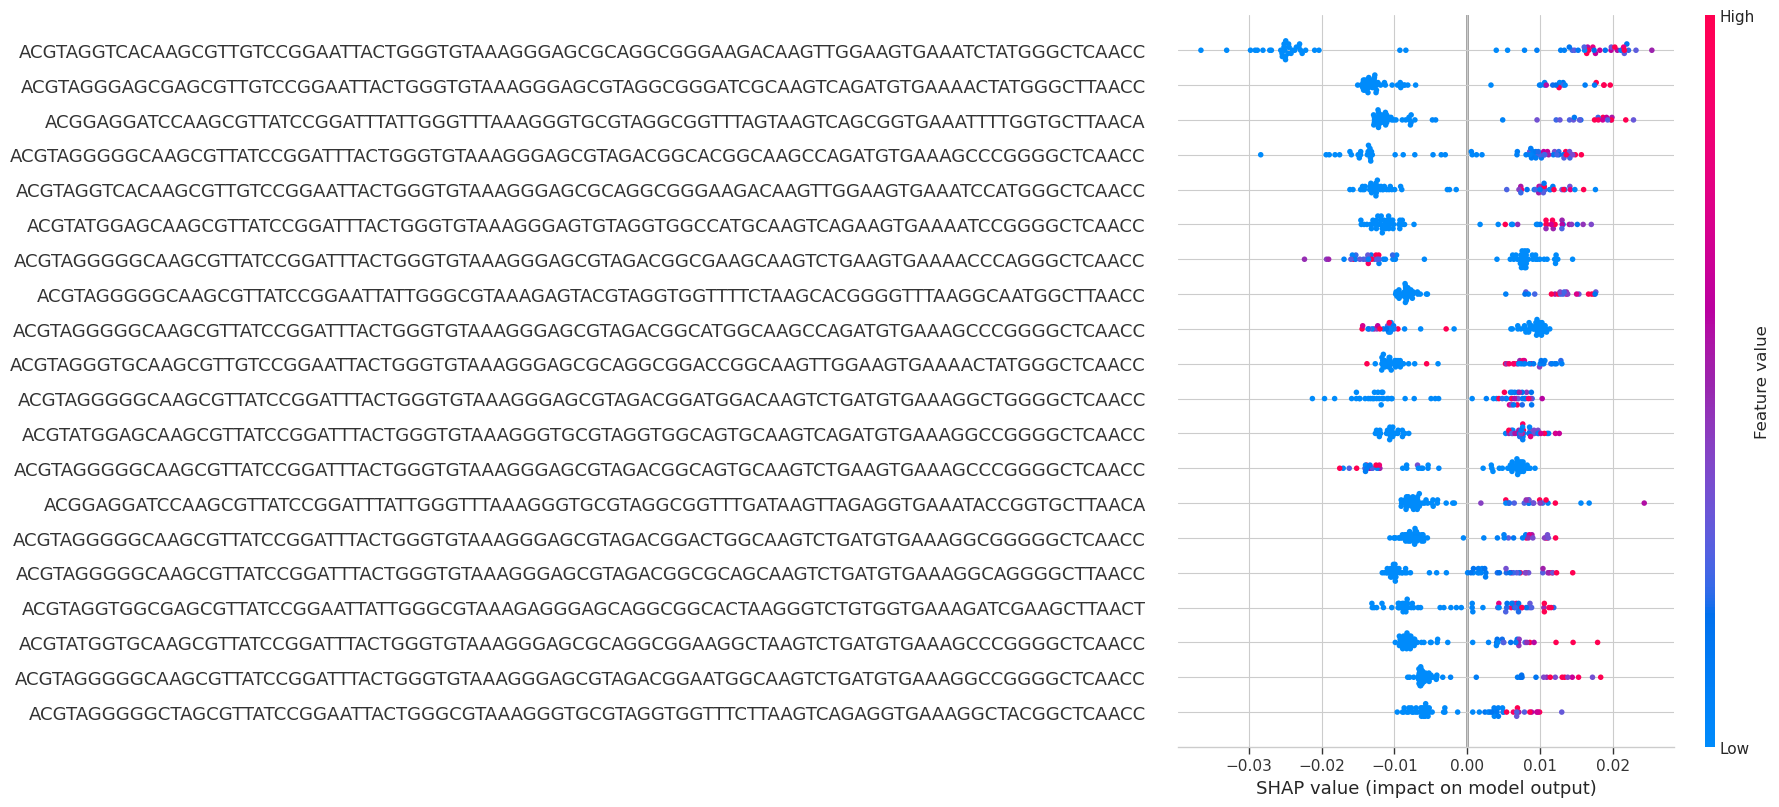

In [32]:
shap.summary_plot(shap_values[:,:,1], X_test)

/home/mwdai/miniforge3/envs/qiime2-amplicon-2025.7/lib/python3.10/site-packages/shap/plots/_beeswarm.py:1150: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



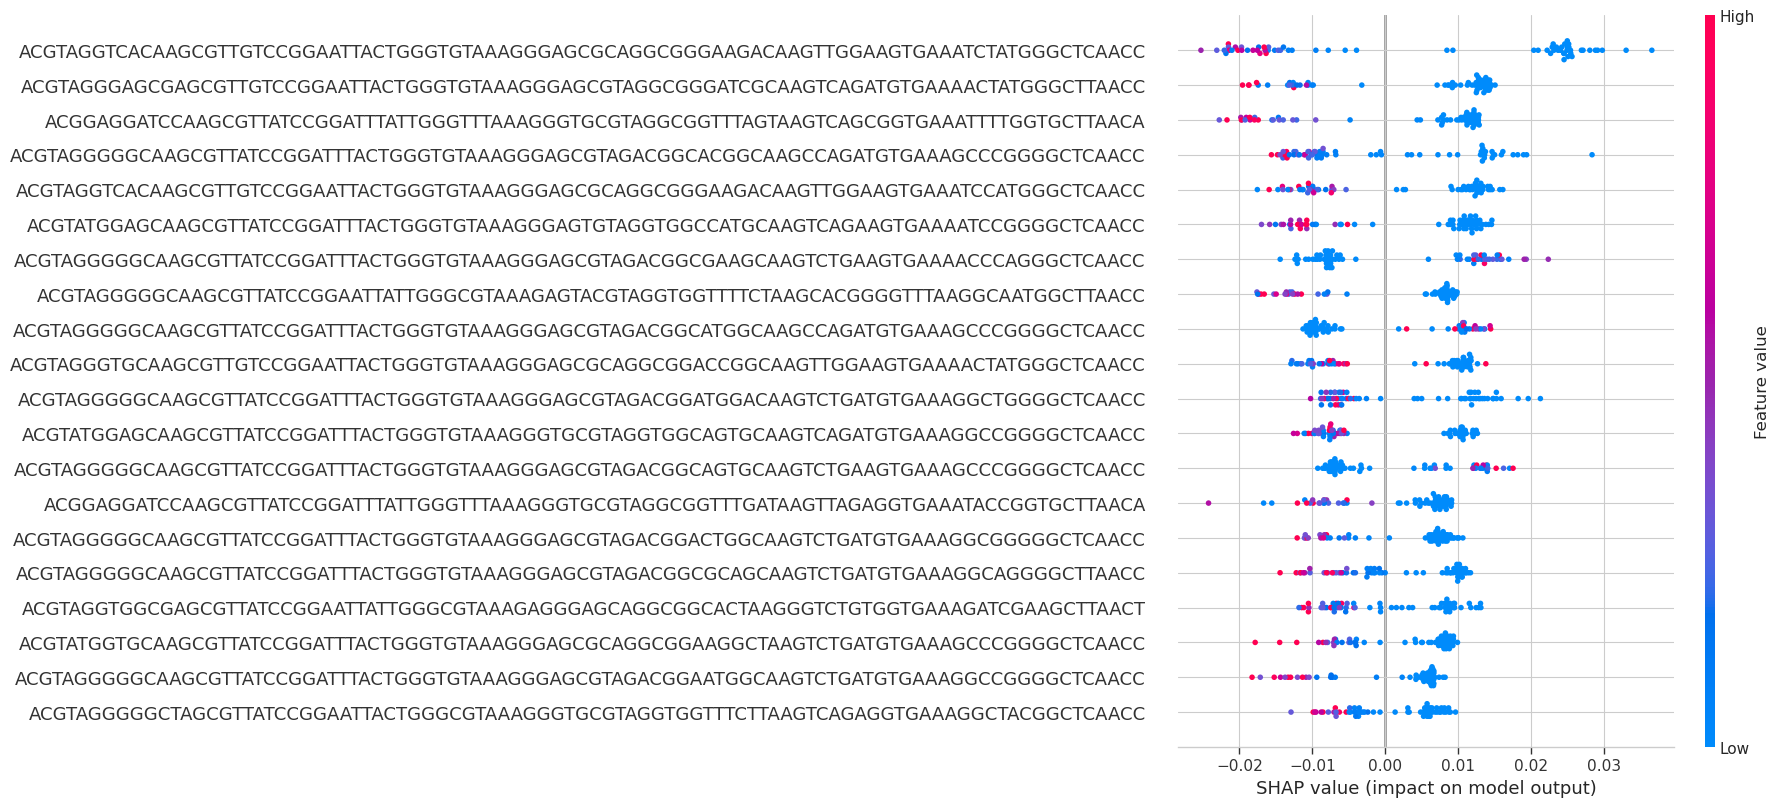

In [33]:
shap.summary_plot(shap_values[:,:,0], X_test)